# Homework 5: 
## Riccardo Tancredi - riccardo.tancredi@studenti.unipd.it
---
Perform the stability analysis for the **Wilson-Cowan** model without refractory dynamics. Set self-excitation and self inhibition to **zero**, 
and $\alpha_E = \alpha_I=1$.

Optional: what is the difference if one considers also the refractory dynamics?

In [1]:
# Simulating the W-C model:
import numpy as np
import matplotlib.pyplot as plt
from ODESolver import RungeKutta4, fixed_point
plt.rcParams.update({'font.size': 10})  
np.random.seed(15122023)

The Wilson - Cowan model is described by a set of two equations representing the evolution in time of concentrations of *excitatory* $x$ and *inhibitory* $y$ neurons.
\begin{equation*}
    \begin{cases}
        \dot {x} = -x\alpha_E + (1-x)r \cdot f(s_E) \\
        \dot {y} = -y\alpha_I + (1-y)r \cdot f(s_I)
    \end{cases}    
\end{equation*}

where $f(s)$ is the sigmoid activation function: 
\begin{equation*}
    f(s) = \frac{1}{1+e^{-s}}
\end{equation*}
and $s$ represents the input current:
\begin{equation*}
    \begin{cases}
        s_E = x\: w_{EE} - y\: w_{EI} + h_E \\
        s_I = -y\: w_{II} + x\: w_{IE} + h_I
    \end{cases}
\end{equation*}
Setting the self-excitation and self-inhibition to zero ($w_{EE} = 0 = w_{II}$) and $\alpha_E = \alpha_I = 1$, one can simplify the system in 
\begin{equation*}
    \begin{cases}
        \dot {x} = -x + f(-y\: w_{EI} + h_E) \\
        \dot {y} = -y +f(x\: w_{IE} + h_I)
    \end{cases}
\end{equation*}

where the refractory effects are neglected too by setting 
\begin{equation*}
    (1-x)r = (1-y)r = 1    
\end{equation*} 

The equilibrium is given by imposing that the two equations above are zero:
\begin{equation*}
    \begin{cases}
        \dot {x} = 0  \\
        \dot {y} = 0 
    \end{cases}
    \implies 
    \begin{cases}
        x^\star = f(-y\: w_{EI} + h_E) = \frac{1}{1+e^{-(h_E - y^\star \: w_{EI})}} \\
        y^\star = f(x\: w_{IE} + h_I) = \frac{1}{1+e^{-(h_I + x^\star \: w_{IE})}}
    \end{cases}
\end{equation*}

Stability analysis is now performed on the the equilibrium point $(x^\star, y^\star)$. The Jacobian of the Wilson - Cowan model is
\begin{equation*}
    J = 
    \begin{pmatrix}
        -1 & -\biggl(1+ e^{-(h_E-y\: w_{EI})}\biggr)^{-2} \cdot e^{-(h_E - y\: w_{EI})}\cdot w_{EI} \\
        \biggl(1+ e^{-(h_I+x\: w_{IE})}\biggr)^{-2} \cdot e^{-(h_I + x\: w_{IE})}\cdot w_{IE} & -1
    \end{pmatrix}
\end{equation*}
and at equilibrium evaluates to 

\begin{equation*}
    J_{x^\star, y^\star} = 
    \begin{pmatrix}
        -1 & -(x^\star)^2 \: w_{EI} \big(1-\frac{1}{x^\star}\big) \\
        -(y^\star)^2 \: w_{IE} \big(1-\frac{1}{y^\star}\big) & -1
    \end{pmatrix}
\end{equation*}

with eigenvalues $\lambda = -1 \pm i \sqrt{k}$, where $k = \vert w_{EI}\vert \: \vert w_{IE}\vert \: x^\star(1-x^\star)\: y^\star (1-y^\star)$. To sum up:
\begin{equation*}
    \boxed{\lambda = -1 \pm i \sqrt{\vert w_{EI}\vert \: \vert w_{IE}\vert \: x^\star(1-x^\star)\: y^\star (1-y^\star)}}
\end{equation*}

One can see immediately that the real part of the two eigenvalues is negative, therefore the equilibrium is stable!

In [2]:
class WC:
    def __init__(self, h_E, h_I, w_EI, w_IE):
        self.h_E = h_E
        self.h_I = h_I
        self.w_EI = w_EI
        self.w_IE = w_IE

    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    # No refractory dynamics
    def __call__(self, t, u):
        h_E, h_I, w_EI, w_IE = self.h_E, self.h_I, self.w_EI, self.w_IE
        x, y = u[0], u[1]
        dx = -x + self.sigmoid(-y*w_EI + h_E)
        dy = -y + self.sigmoid(x*w_IE + h_I)
        return dx, dy

In [3]:
h_E, h_I, w_EI, w_IE = [.5, -.5, 1., 1.]
WC_simulation = WC(h_E=h_E,
                    h_I=h_I,
                    w_EI=w_EI,
                    w_IE=w_IE)

evolution = RungeKutta4(WC_simulation)
x_0 = 0.7
y_0 = 0.3
evolution.set_initial_condition([x_0, y_0])
t, u = evolution.solve(t_span=(0, 10), N=10000)

In [4]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

x_star = fixed_point(lambda x, h_I, h_E, w_EI, w_IE: sigmoid(h_E-w_EI*sigmoid(h_I+x*w_IE)),
                     initial_guess=0.1, tolerance=1e-6, max_iterations=100).compute(extra_params=[h_I, h_E, w_EI, w_IE])

y_star = fixed_point(lambda y, h_I, h_E, w_EI, w_IE: sigmoid(h_I+w_IE*sigmoid(h_E-y*w_EI)),
                     initial_guess=0.1, tolerance=1e-6, max_iterations=100).compute(extra_params=[h_I, h_E, w_EI, w_IE])

# y_star = sigmoid(h_I+x_star*w_IE)
ind = np.where(np.array([np.allclose(u[i, 0], [x_star], rtol=1e-3, atol=1e-3) for i in range(u.shape[0])]) == True)[0][0]
t_0 = t[ind]

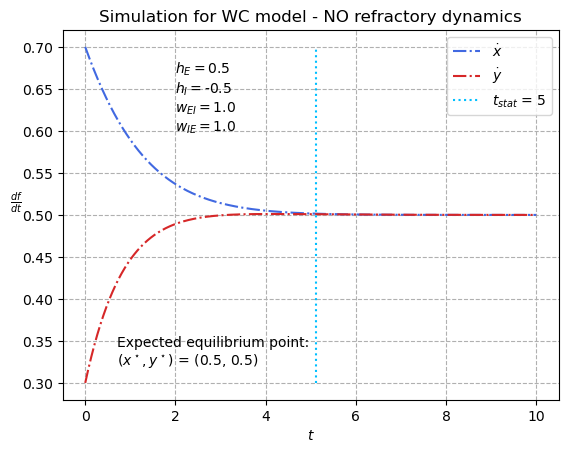

In [5]:
plt.plot(t, u[:, 0], label=r'$\dot {x}$', ls='-.', color='royalblue')
plt.plot(t, u[:, 1], label=r'$\dot {y}$', ls='-.', color='tab:red')

plt.vlines(t_0, min(u[:, 1]), max(u[:, 0]), color="deepskyblue", ls=':', label=r'$t_{stat}$' + f' = {int(t_0)}')
plt.xlabel(r'$t$')
plt.ylabel(r'$\frac{df}{dt}\quad$', rotation=0)
plt.text(2, 0.6, r'$h_E =$'+f'{h_E}\n'+r'$h_I =$'+f'{h_I}\n'+r'$w_{EI} =$'+f'{w_EI}\n'+r'$w_{IE} =$'+f'{w_IE}')
plt.text(0.7, 0.32, 'Expected equilibrium point:\n'+r'$(x^\star, y^\star)$ = '+f'({round(x_star, 1)}, {round(y_star, 1)})')
plt.title('Simulation for WC model - NO refractory dynamics')
plt.legend()
plt.grid(ls='--')
plt.savefig('Simulation_WC_no_refractory.png', dpi=300)
plt.show()

*Optional*:

If one also allows refractory dynamics, then 
\begin{equation*}
    \begin{cases}
        x^\star = (1-x^\star)r \cdot f(-y\: w_{EI} + h_E) = \frac{(1-x^\star)r}{1+e^{-(h_E - y^\star \: w_{EI})}} \\
        y^\star = (1-y^\star)r \cdot f(x\: w_{IE} + h_I) = \frac{(1-y^\star)r}{1+e^{-(h_I + x^\star \: w_{IE})}}
    \end{cases}
\end{equation*}
This leads to 
\begin{equation*}
    \begin{cases}
        x^\star = \frac{r}{r+1+e^{-(h_E - y^\star \: w_{EI})}} \\
        y^\star = \frac{r}{r+1+e^{-(h_I + x^\star \: w_{IE})}}
    \end{cases}
\end{equation*}

The Jacobian now reads
\begin{equation*}
    J = 
    \begin{pmatrix}
        -1-\frac{r}{1+e^{-(h_E - y^\star \: w_{EI})}} & (1-x^\star)r \cdot \biggl[-\biggl(1+ e^{-(h_E-y\: w_{EI})}\biggr)^{-2} \cdot e^{-(h_E - y\: w_{EI})}\cdot w_{EI}\biggr]\\
        (1-y^\star)r\cdot \biggl[\biggl(1+ e^{-(h_I+x\: w_{IE})}\biggr)^{-2} \cdot e^{-(h_I + x\: w_{IE})}\cdot w_{IE}\biggr] & -1 -\frac{r}{1+e^{-(h_I + x^\star \: w_{IE})}}
    \end{pmatrix}
\end{equation*}

Substituting $(x^\star, y^\star)$ into the Jacobian one gets 
\begin{equation*}
    J_{x^\star, y^\star} =    
    \begin{pmatrix}
        -\frac{1}{1-x^\star} & -\frac{x^\star}{r(1-x^\star)}(r-(r+1)x^\star) \cdot w_{EI}\\
        \frac{y^\star}{r(1-y^\star)}(r-(r+1)y^\star) \cdot w_{IE} & -\frac{1}{1-y^\star}
    \end{pmatrix}
\end{equation*}

The eigenvalues can be calculated accordingly, leading to 
\begin{equation*}
    \boxed{\lambda = \frac{-l\pm \sqrt{l^2-4k}}{2}}
\end{equation*}
where
\begin{equation*}
    l = \frac{1}{1-x^\star} + \frac{1}{1-y^\star} > 0
\end{equation*}
is always positive, and 
\begin{equation*}
    k = \frac{1}{(1-x^\star)(1-y^\star)}\biggl(1+\frac{x^\star \: y^\star}{r^2} \vert w_{IE} \vert \: \vert w_{EI} \vert \cdot \big(r-(r+1)x^\star\big) \big(r-(r+1)y^\star\big) \biggr)
\end{equation*}
If $l^2-4k < 0$ then the dynamics is the same as before, where the refractory part was neglected: $l$ is always positive so $\lambda$ will be of the form 
\begin{equation*}
    \boxed{\lambda = -\vert\tilde{l}\vert\pm i\tilde{k}} \quad\quad \:\text{if}\quad l^2-4k < 0
\end{equation*}
Otherwise, if $l^2-4k >0$ and $\sqrt{l^2-4k}>l $, since $l>0$ (always) if one is able to find when $k<0$ then $\lambda >0$ and there will be at least one positive eigenvalue, making the equilibrium unstable.

\begin{equation*}
    k<0 \iff r^2 + x^\star y^\star \:\vert w_{EI}\vert \: \vert w_{IE}\vert \biggl(r-(r+1)x^\star\biggr)\biggl(r-(r+1)y^\star\biggr) < 0    
\end{equation*}
But actually this condition is **never met**, so the system will always allow stable equilibria. 

What changes when considering a refractory dynamics is that the neuron's excitability is reduced, and it cannot respond to incoming signals. This refractory variable decays over time, allowing the neuron to recover its excitability gradually. The refractory period introduces time delays and non-linearities that affect how neurons interact and synchronize.

In [6]:
class WC_refractory:
    def __init__(self, r, h_E, h_I, w_EI, w_IE):
        self.r = r
        self.h_E = h_E
        self.h_I = h_I
        self.w_EI = w_EI
        self.w_IE = w_IE

    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    # No refractory dynamics
    def __call__(self, t, u):
        r, h_E, h_I, w_EI, w_IE = self.r, self.h_E, self.h_I, self.w_EI, self.w_IE
        x, y = u[0], u[1]
        dy = -y + (1-y)*r*self.sigmoid(x*w_IE + h_I)
        dx = -x + (1-x)*r*self.sigmoid(-y*w_EI + h_E)
        return dx, dy

In [7]:
r, h_E, h_I, w_EI, w_IE = [.5, .5, -.5, 1., 1.]
WC_simulation = WC_refractory(r=r, 
                              h_E=h_E,
                              h_I=h_I,
                              w_EI=w_EI,
                              w_IE=w_IE)

evolution = RungeKutta4(WC_simulation)
x_0 = 0.6
y_0 = 0.1
evolution.set_initial_condition([x_0, y_0])
t, u = evolution.solve(t_span=(0, 10), N=10000)

In [8]:
def mod_sigmoid(x, r):
    return r / (r + 1. + np.exp(-x))

x_star = fixed_point(lambda x, r, h_I, h_E, w_EI, w_IE: mod_sigmoid(h_E-w_EI*mod_sigmoid(h_I+x*w_IE, r), r),
                     initial_guess=0.1, tolerance=1e-6, max_iterations=100).compute(extra_params=[r, h_I, h_E, w_EI, w_IE])

y_star = fixed_point(lambda y, r, h_I, h_E, w_EI, w_IE: mod_sigmoid(h_I+w_IE*mod_sigmoid(h_E-y*w_EI, r), r),
                     initial_guess=0.1, tolerance=1e-6, max_iterations=100).compute(extra_params=[r, h_I, h_E, w_EI, w_IE])

# y_star = mod_sigmoid(h_I+x_star*w_IE, r)
ind = np.where(np.array([np.allclose(u[i, 0], [x_star], rtol=1e-3, atol=1e-3) for i in range(u.shape[0])]) == True)[0][0]
t_0 = t[ind]

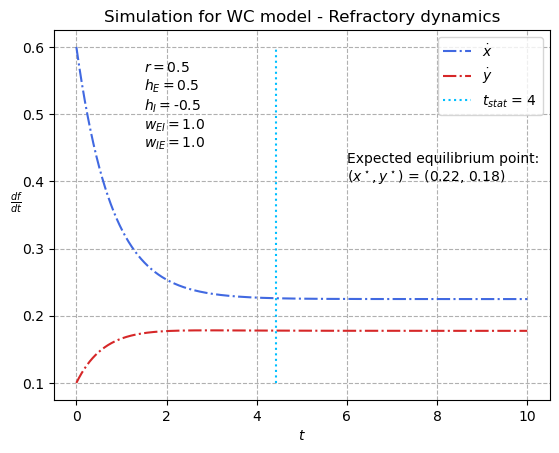

In [9]:
plt.plot(t, u[:, 0], label=r'$\dot {x}$', ls='-.', color='royalblue')
plt.plot(t, u[:, 1], label=r'$\dot {y}$', ls='-.', color='tab:red')

plt.vlines(t_0, min(u[:, 1]), max(u[:, 0]), color="deepskyblue", ls=':', label=r'$t_{stat}$' + f' = {int(t_0)}')
plt.xlabel(r'$t$')
plt.ylabel(r'$\frac{df}{dt}\quad$', rotation=0)
plt.text(1.5, 0.45, r'$r =$'+f'{r}\n'+r'$h_E =$'+f'{h_E}\n'+r'$h_I =$'+f'{h_I}\n'+r'$w_{EI} =$'+f'{w_EI}\n'+r'$w_{IE} =$'+f'{w_IE}')
plt.text(6, 0.4, 'Expected equilibrium point:\n'+r'$(x^\star, y^\star)$ = '+f'({round(x_star, 2)}, {round(y_star, 2)})')
plt.title('Simulation for WC model - Refractory dynamics')
plt.legend()
plt.grid(ls='--')
plt.savefig('Simulation_WC_with_refractory.png', dpi=300)
plt.show()